In [1]:
# Some enhancements :
# - Increase number of 

from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline 

import pickle
import lasagne
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as T
from lasagne.layers import DenseLayer, DropoutLayer, NonlinearityLayer, InputLayer
from lasagne.layers import Pool2DLayer as PoolLayer
#from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax, leaky_rectify
from lasagne.layers import get_output, get_all_params
import theano

from samplelayer import SimpleSampleLayer

#theano.config.optimizer = 'None'
theano.config.exception_verbosity='high'
# theano.config.compute_test_value = 'warn' 

/home/icarus/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)


In [2]:
TRAIN_FILE = 'x_train_1000Samples.p'
VALIDATION_FILE = 'x_train_1000SamplesValidation.p'
TARGET_FILE = 'targets_train_1000Samples.p'
TARGET_VALIDATION_FILE = 'targets_train_1000SamplesValidation.p'

# TRAIN_FILE = 'x_train.p'
# VALIDATION_FILE = 'x_train_validation.p'
# TARGET_FILE = 'targets_train.p'
# TARGET_VALIDATION_FILE = 'targets_train_validation.p'

In [3]:
def load_data():
    with open(TRAIN_FILE, 'r') as f:
        x_train = pickle.load(f)
    with open(VALIDATION_FILE, 'r') as f:
        x_valid = pickle.load(f)
    with open(TARGET_FILE, 'r') as f:
        targets_train = pickle.load(f)
    with open(TARGET_VALIDATION_FILE, 'r') as f:
        targets_valid = pickle.load(f)
    

    x_train = np.asarray(x_train).squeeze(axis=1)
    x_valid = np.asarray(x_valid).squeeze(axis=1)
    targets_train = np.asarray(targets_train, dtype=np.float32)
    targets_valid = np.asarray(targets_valid, dtype=np.float32)
    
    return x_train, x_valid, targets_train, targets_valid

In [4]:
x_train, x_valid, targets_train, targets_valid = load_data()

print x_train.shape
print x_valid.shape
print targets_train.shape
print targets_valid.shape

(3930, 3, 224, 224)
(1973, 3, 224, 224)
(3930, 4)
(1973, 4)


In [5]:
NUM_LATENT_Z = 2
NUM_CLASSES = 4

def create_network():
    net = {}

    # VGG Net
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_4'], 2)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_4'], 2)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_4'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8_not_used'] = DenseLayer(net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob_not_used'] = NonlinearityLayer(net['fc8_not_used'], softmax)
    
    set_vgg_params(net)

    # VAE
    net['enc_vae'] = DenseLayer(net['fc7_dropout'], num_units=1024, nonlinearity=leaky_rectify)
    net['muq_vae'] = DenseLayer(net['enc_vae'], num_units=NUM_LATENT_Z, nonlinearity=None)     #mu(x)
    net['logvarq_vae'] = DenseLayer(net['enc_vae'], num_units=NUM_LATENT_Z, nonlinearity=lambda x: T.clip(x,-10,10)) #logvar(x)
    net['z_vae'] = SimpleSampleLayer(mean=net['muq_vae'], log_var=net['logvarq_vae']) # sample a latent representation z \sim q(z|x) = N(mu(x),logvar(x))
#     net['z_vae'] = net['muq_vae']
    net['in_z_vae'] = InputLayer(shape=(None, NUM_LATENT_Z))
    #net['dec_vae'] = DenseLayer(net['in_z_vae'], num_units=128, nonlinearity=leaky_rectify)

    # Vanilla network
    net['fc8'] = DenseLayer(net['in_z_vae'], num_units=1024)
    net['fc8_dropout'] = DropoutLayer(net['fc8'], p=0.5)
    net['fc9'] = DenseLayer(net['fc8_dropout'], num_units=4, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc9'], softmax)

    return net

def set_vgg_params(net):
    model = pickle.load(open('vgg19.pkl'))

    # Remove the trainable argument from the layers that can potentially have it
    for key, val in net.iteritems():
        if not ('dropout' or 'pool' in key):
            net[key].params[net[key].W].remove("trainable")
            net[key].params[net[key].b].remove("trainable")

    lasagne.layers.set_all_param_values(net['prob_not_used'], model['param values'])


In [6]:
class VAEHelper:

    @staticmethod
    def create_theano_functions(net):
        sym_x = T.tensor4('x')
#         sym_x.tag.test_value = np.zeros((10,3,224,224), dtype = np.float32)
        sym_z = T.matrix('z')
#         sym_z.tag.test_value = np.zeros((10,2), dtype = np.float32)
        sym_y = T.matrix('y')
#         sym_y.tag.test_value = np.zeros((10,4), dtype = np.float32)
        
        z_train, muq_train, logvarq_train = get_output([net['z_vae'], net['muq_vae'], net['logvarq_vae']],
                                                       {net['input']: sym_x}, deterministic=False)
        prob_train = get_output(net['prob'], {net['in_z_vae']: z_train}, deterministic=False)

        z_eval, muq_eval, logvarq_eval = get_output([net['z_vae'], net['muq_vae'], net['logvarq_vae']],
                                                    {net['input']: sym_x}, deterministic=True)
        prob_eval = get_output(net['prob'], {net['in_z_vae']: z_eval}, deterministic=True)

        prob_sample = get_output(net['prob'], {net['in_z_vae']: sym_z}, deterministic=True)

        LL_train, logpx_train, KL_train = VAEHelper.LogLikelihood(prob_train, sym_y, muq_train, logvarq_train)
        LL_eval, logpx_eval, KL_eval = VAEHelper.LogLikelihood(prob_eval, sym_y, muq_eval, logvarq_eval)

        all_params = get_all_params([net['z_vae'],net['prob']],trainable=True)

        # Let Theano do its magic and get all the gradients we need for training
        all_grads = T.grad(-LL_train, all_params)

        # Set the update function for parameters. The Adam optimizer works really well with VAEs.
        updates = lasagne.updates.adam(all_grads, all_params, learning_rate=1e-3)
#         updates = lasagne.updates.nesterov_momentum(all_grads, all_params, learning_rate=1e-1)

        f_train = theano.function(inputs=[sym_x, sym_y],
                                  outputs=[LL_train, logpx_train, KL_train],
                                  updates=updates)

        f_eval = theano.function(inputs=[sym_x, sym_y],
                                 outputs=[LL_eval, logpx_eval, KL_eval])

        f_z = theano.function(inputs=[sym_x],
                              outputs=[z_eval])

        f_sample = theano.function(inputs=[sym_z],
                                   outputs=[prob_sample])

        f_recon = theano.function(inputs=[sym_x],
                                  outputs=[prob_eval])

        return f_train, f_eval, f_z, f_sample, f_recon

    @staticmethod
    def LogLikelihood(mux, x, muq, logvarq):
        log_px_given_z = VAEHelper.log_bernoulli(x, mux, eps=1e-6).sum(axis=1).mean() #note that we sum the latent dimension and mean over the samples
        KL_qp = VAEHelper.kl_normal2_stdnormal(muq, logvarq).sum(axis=1).mean() #* 0 # To ignore the KL term
        LL = log_px_given_z - KL_qp
        return LL, log_px_given_z, KL_qp
    
    @staticmethod
    def log_bernoulli(x, p, eps=0.0):
        p = T.clip(p, eps, 1.0 - eps)
        return -T.nnet.binary_crossentropy(p, x)
    
    @staticmethod
    def kl_normal2_stdnormal(mean, log_var):
        return -0.5*(1 + log_var - mean**2 - T.exp(log_var))

In [22]:
# Create network
net = create_network()

In [23]:
f_train, f_eval, f_z, f_sample, f_recon = VAEHelper.create_theano_functions(net)

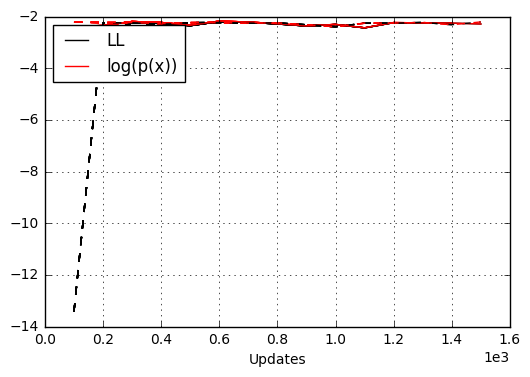

In [24]:
batch_size = 10
samples_to_process = 1e4
val_interval = 100

LL_train, KL_train, logpx_train = [],[],[]
LL_valid, KL_valid, logpx_valid = [],[],[]
samples_processed = 0
# plt.figure(figsize=(12, 24))
plt.figure()
valid_samples_processed = []

x_recons = []
y_valid_batches = []

try:
    while samples_processed < samples_to_process:
        _LL_train, _KL_train, _logpx_train = [],[],[]
        idxs = np.random.choice(range(x_train.shape[0]), size=(batch_size), replace=False)  
        x_batch = x_train[idxs]
        y_batch = targets_train[idxs]
        out = f_train(x_batch, y_batch)
        samples_processed += batch_size
           
        if samples_processed % val_interval == 0:
            valid_samples_processed += [samples_processed]
            #out = f_eval(x_train, y_batch) # this is causing OOM errors, we need to use x_batch instead and average
            LL_train += [out[0]] 
            logpx_train += [out[1]]
            KL_train += [out[2]]
            
            idxs_eval = np.random.choice(range(x_valid.shape[0]), size=(batch_size), replace=False) 
            x_valid_batch = x_valid[idxs_eval]
            y_valid_batch = targets_valid[idxs_eval]
            y_valid_batches.append(y_valid_batch)
            
            out = f_eval(x_valid_batch, y_valid_batch)
            LL_valid += [out[0]]
            logpx_valid += [out[1]]
            KL_valid += [out[2]]
            
            z_eval = f_z(x_valid_batch)[0]
            x_sample = f_sample(np.random.normal(size=(batch_size, NUM_LATENT_Z)).astype('float32'))[0]
            x_recon = f_recon(x_valid_batch)[0]
            x_recons.append(x_recon)
            
#             plt.subplot(NUM_CLASSES+2,2,1)
            plt.legend(['LL', 'log(p(x))'], loc=2)
            plt.xlabel('Updates')
            plt.plot(valid_samples_processed, LL_train, color="black")
            plt.plot(valid_samples_processed, logpx_train, color="red")
            plt.plot(valid_samples_processed, LL_valid, color="black", linestyle="--")
            plt.plot(valid_samples_processed, logpx_valid, color="red", linestyle="--")
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')
            
            plt.savefig("out52.png")
            display(Image(filename="out52.png"))
            clear_output(wait=True)

except KeyboardInterrupt:
    pass

In [25]:
x_recons_np = np.asarray(x_recons)
print x_recons_np.shape

y_valid_batches_np = np.asarray(y_valid_batches)
print y_valid_batches_np.shape

(15, 10, 4)
(15, 10, 4)


In [26]:
x_recons_cc = np.concatenate(x_recons_np, 0)
y_valid_batches_cc = np.concatenate(y_valid_batches_np, 0)
print x_recons_cc.shape
print y_valid_batches_cc.shape

res = np.argmax(x_recons_cc, axis=1)
print res

(150, 4)
(150, 4)
[0 3 0 0 3 3 0 0 3 2 1 0 0 1 0 2 1 0 1 2 2 2 2 3 2 3 0 0 2 0 0 3 3 2 1 1 3
 2 3 2 0 2 2 0 0 2 2 0 1 0 1 2 0 0 1 2 0 0 2 2 2 2 2 2 2 0 2 2 2 0 0 2 2 0
 0 2 0 1 0 0 2 0 0 2 2 0 0 0 0 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 0 1 2 2 2 2
 2 1 2 2 2 1 2 2 2 0 1 2 2 1 2 2 1 2 2 0 0 1 1 2 2 2 0 0 0 0 0 2 1 2 2 2 0
 1 0]


In [27]:
val = np.argmax(y_valid_batches_cc, axis=1)
print val

[2 0 3 2 3 3 2 3 3 1 0 3 2 3 0 1 2 2 1 0 1 2 1 3 3 3 3 1 2 2 2 3 1 0 2 0 3
 2 3 1 3 3 3 1 1 1 3 0 0 3 2 1 1 1 2 3 1 0 2 0 2 1 3 2 1 2 3 1 1 0 0 3 1 0
 0 0 2 1 3 3 3 0 1 1 1 2 1 0 1 1 1 1 3 2 0 0 1 1 2 1 1 1 0 2 0 0 2 2 0 1 0
 0 2 1 1 3 3 0 2 1 3 1 3 0 1 3 1 0 3 2 1 3 1 3 0 1 1 0 2 3 1 2 1 3 0 1 2 2
 0 0]


In [28]:
print np.where(res==val)

(array([  4,   5,   8,  14,  18,  21,  23,  25,  28,  31,  36,  37,  38,
        47,  57,  58,  60,  63,  69,  70,  73,  74,  77,  81,  87,  93,
        96,  98, 101, 103, 105, 107, 118, 121, 124, 129, 132, 137, 146, 149]),)


In [33]:
print len(np.where(res==val)[0]) / (float) (len(y_valid_batches_cc))

0.266666666667
